### Import relevant libraries

In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# for garbage collection
import gc

# for warnings
import warnings
warnings.filterwarnings("ignore")

# utility libraries
import os
import copy
import tqdm
import numpy as np 
import pandas as pd 
import cv2, random, time, shutil, csv
import tensorflow as tf 
import math
import time
#from util import *
import matplotlib.pyplot as plt

# keras libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
# change colab flag to false if train using jupyter notebook else set to true if using colab
COLAB_FLAG = True

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [ ]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


### Preparing the dataset

In [ ]:
INPUT_SHAPE = (299,299,3)
NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'
print(NPZ_PATH)
NPZ_PATH_TEST = f'{COLAB_FILEPATH}Datasets/preprocessed_data_test_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'
print(NPZ_PATH_TEST)

./drive/My Drive/4041-dog-breed-classification/Datasets/preprocessed_data_299x299.npz
./drive/My Drive/4041-dog-breed-classification/Datasets/preprocessed_data_test_299x299.npz


In [ ]:
# check the numpy array information and the size conversion
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")

In [ ]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH)
print(loaded.files)
Xarr = loaded["X"]
Y = loaded["Y"]
Y_oh = loaded["Y_oh"]
del loaded
gc.collect()

print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y', 'Y_oh']
Time taken to load compressed data: 29.060401916503906


In [ ]:
# print out shape, dtype and data size
nparray_info("Images (npz)", Xarr)
print()
nparray_info("Labels (npz)", Y)
print()
nparray_info("Labels One-hot (npz)", Y_oh)

Images (npz)
-  shape	 (10222, 299, 299, 3)
-  dtype	 uint8
- nbytes	 2741571066 (2.55 GB)

Labels (npz)
-  shape	 (10222, 1)
-  dtype	 uint8
- nbytes	 10222 (9.98 KB)

Labels One-hot (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [ ]:
Y

array([[19],
       [37],
       [85],
       ...,
       [ 3],
       [75],
       [28]], dtype=uint8)

In [ ]:
# get the respective labels
# loading labels from csv file
df = pd.read_csv(f"{COLAB_FILEPATH}Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = sorted(df.breed.unique())
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


### Utils Function

In [ ]:
def generate_features_data(feats_dict, saving_path=f"{COLAB_FILEPATH}Datasets/feaatures.h5"):
    assert(type(saving_path) is str)
    os.makedirs(os.path.dirname(saving_path), exist_ok=True)
    try:
        with h5py.File(saving_path, 'w') as h5:
            for model_name in feats_dict:
                print(f"saving features for {model_name}...")
                h5.create_dataset(model_name, data= feats_dict[model_name])
        print("features saved")
    except Exception as e:
        print(e)
        
def load_features_data(saving_path=f"{COLAB_FILEPATH}Datasets/feaatures.h5"):
    feats_dict = {}
    try:
        feats_dict = {}
        with h5py.File(saving_path, "r") as h5:
            #print("h5.keys", h5.keys())
            for model_name in h5:
                print(f"loading features for {model_name}...")
                feats_dict[model_name] = h5[model_name][:]
        print("features loaded")
    except Exception as e:
        print(e)
    return feats_dict
        

def plot_model_history(history, folder=f"{COLAB_FILEPATH}plots/", saving_name="model_loss_accuracy"):
    plt.style.use("ggplot")
    plt.figure(figsize=(16, 6))

    # plot for loss
    ax = plt.subplot(1, 2, 1)
    # ensure ploting never plot beyond 10
    #y_max = (max(history.history["loss"]), max(history.history["val_loss"]))
    #y_max = min(10.0, max(y_max))
    #ax.set_ylim(ymax=y_max)
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot( history.history["val_loss"], label="val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # plot for accuracy
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim([0,1.2]) # fix y-range for eazy comparison 
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")

    plt.title("Model Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

def plot_learning_rate( history, folder=f"{COLAB_FILEPATH}plots/", saving_name="model_learn_rate"):
    # history only contain lr when lrScheduler used 
    #assert('lr' in history.history.keys()), "model history does not contain lr, ensure lr related callback is used"
    
    # the learning rate schedule
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 6))
    plt.plot( history.history["lr"], label="learn rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

def avg(lst):
    return sum(lst) / len(lst)

### Feature Extraction

In [ ]:
# FEATURE EXTRACTION OF TRAINING ARRAYS
AUTO = tf.data.experimental.AUTOTUNE
def get_features(model_name, data_preprocessor, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    dataset = tf.data.Dataset.from_tensor_slices(data)


    def preprocess(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_brightness(x, 0.5)
        return x

    ds = dataset.map(preprocess, num_parallel_calls=AUTO).batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False,
                                input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)


    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    
    # deleting variables
    del(feature_extractor, base_model, preprocessor, dataset)
    gc.collect()
    return feature_maps

In [ ]:
# FEATURE EXTRACTION OF VALIDAION AND TESTING ARRAYS
def get_valfeatures(model_name, data_preprocessor, data):
    '''
    Same as above except not image augmentations applied.
    Used for feature extraction of validation and testing.
    '''

    dataset = tf.data.Dataset.from_tensor_slices(data)

    ds = dataset.batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    return feature_maps

In [ ]:
# generate feature dictionary 
def generate_model_features(feat_func, model_names, models, preprocs, array):
    print(f"Beginning extraction with {feat_func.__name__}\n")
    feats_dict = {}

    for i in range(len(models)):
        print(f"\nStarting feature extraction with {models[i].__name__} using {preprocs[i].__name__}\n")
        # applying the above function and storing in list
        feats_dict[model_names[i]] = feat_func(models[i], preprocs[i], array)
        
    # memory saving
    del(array)
    gc.collect()
    return feats_dict

In [ ]:
# RETURNING CONCATENATED FEATURES
def get_concat_features(model_names, feats_dict):
    feats_list = []
    
    for name in model_names:
        print(f"collect features for {name}...")
        feats_list.append( feats_dict[name] )

    # features concatenating
    final_feats = np.concatenate(feats_list, axis=-1)
    # memory saving
    del(feats_list)
    gc.collect()
    return final_feats

In [ ]:
# DEFINING models and preprocessors imports
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
densenet_preprocessor = preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input 
mobilenet_preprocessor = preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
restnet_preprocessor = preprocess_input

# collecting top 6 models' features for evaluation later
model_names = ["Xception", "DenseNet169", "InceptionResNetV2", "MobileNet", "InceptionV3", "RestNet50"]
models = [Xception, DenseNet169, InceptionResNetV2, MobileNet, InceptionV3, ResNet50 ]
preprocs = [xception_preprocessor, densenet_preprocessor, inc_resnet_preprocessor, 
            mobilenet_preprocessor, inception_preprocessor, restnet_preprocessor]

In [ ]:
import h5py 
# Perform feature extraction and save as h5 file
saving_path = os.path.join(f"{COLAB_FILEPATH}Datasets", f'features.h5')
print(saving_path)
t = time.time()
# feats_dict = {}
if (os.path.isfile(saving_path)):
    feats_dict = load_features_data(saving_path)
else:
    feats_dict = generate_model_features(get_features, model_names, models, preprocs, Xarr)
    generate_features_data(feats_dict, saving_path)
gc.collect()
print(f'Time taken: {time.time()-t}')

./drive/My Drive/4041-dog-breed-classification/Datasets/features.h5
loading features for DenseNet169...
loading features for InceptionResNetV2...
loading features for InceptionV3...
loading features for MobileNet...
loading features for RestNet50...
loading features for Xception...
features loaded
Time taken: 3.115143299102783


In [ ]:
for name in feats_dict:
    nparray_info(name, feats_dict[name])
    #print(name)

DenseNet169
-  shape	 (10222, 1664)
-  dtype	 float32
- nbytes	 68037632 (64.89 MB)
InceptionResNetV2
-  shape	 (10222, 1536)
-  dtype	 float32
- nbytes	 62803968 (59.89 MB)
InceptionV3
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)
MobileNet
-  shape	 (10222, 1024)
-  dtype	 float32
- nbytes	 41869312 (39.93 MB)
RestNet50
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)
Xception
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=0)

my_callback=[EarlyStop_callback]

In [ ]:
epochs=80
batch_size=128
dropout=0.9
alpha = 0.001

In [ ]:
from sklearn.model_selection import StratifiedKFold

def kfold_split(X, Y_hot, train_idx, valid_idx):
    x_train_fold = X[train_idx, :]
    y_train_fold = Y_hot[train_idx, :]
    x_val_fold = X[valid_idx]
    y_val_fold = Y_hot[valid_idx, :]
    return x_train_fold, y_train_fold, x_val_fold, y_val_fold

# construct model
def buildModel(input_size,best_model):
    dnn = keras.models.Sequential([
        InputLayer(input_size),
        Dropout(dropout),
        Dense(120, activation='softmax')
    ])
    if best_model:
        dnn.compile(optimizer=Adam(lr=alpha, beta_1=0.9, beta_2=0.999),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    else:
        dnn.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return dnn

def trainModels(X, Y, plot_model=True, best_model=False):
    # Use K fold of 5, to ensure train:validation is 80:20
    splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=10).split(X, Y))

    trained_models = []
    val_accuracy = []
    val_losses = []
    train_accuracy = []
    train_losses = []

    #Prepare And Train DNN model
    for i, (train_idx, valid_idx) in enumerate(splits): 
        print(f"\nStarting fold {i+1}")
        x_train_fold, y_train_fold, x_val_fold, y_val_fold = kfold_split(X, Y_oh, train_idx, valid_idx)

        dnn = buildModel(X.shape[1:],best_model)
        print("Training...")
        #Train simple DNN on extracted features.
        h = dnn.fit(x_train_fold, y_train_fold,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data = (x_val_fold, y_val_fold),
                    callbacks=my_callback)
        
        print("Evaluating model ...")
        model_res_val = dnn.evaluate(x_val_fold, y_val_fold)
        model_res_train = dnn.evaluate(x_train_fold, y_train_fold)
        train_accuracy.append(model_res_train[1])
        train_losses.append(model_res_train[0])
        val_accuracy.append(model_res_val[1])
        val_losses.append(model_res_val[0])
        trained_models.append(dnn)
        if (plot_model):
            plot_model_history(h, saving_name=f"fold_{i+1}_LA")

    print('\nCV Score')
    print(f"TrainAccuracy \tavg: {avg(train_accuracy):.5f} \tmax: {max(train_accuracy):.5f}")
    print(f"TrainLoss \tavg: {avg(train_losses):.5f} \tmin: { min(train_losses):.5f}")
    print(f"ValAccuracy \tavg: {avg(val_accuracy):.5f} \tmax: {max(val_accuracy):.5f}")
    print(f"ValLoss \tavg: {avg(val_losses):.5f} \tmin: {min(val_losses):.5f}\n")
    return trained_models, val_accuracy, val_losses, train_accuracy, train_losses


## Test on the combination of the best 3 models

Feature extractions for ['Xception', 'DenseNet169', 'InceptionResNetV2']
collect features for Xception...
collect features for DenseNet169...
collect features for InceptionResNetV2...

Starting fold 1
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1770 - accuracy: 0.9424


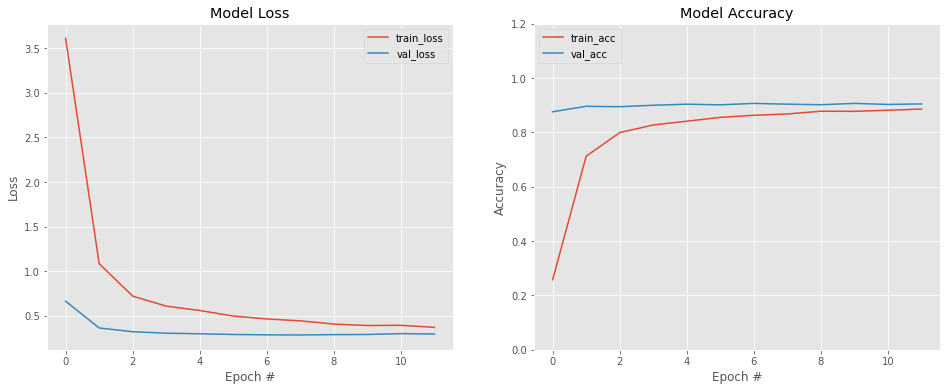


Starting fold 2
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1309 - accuracy: 0.9568


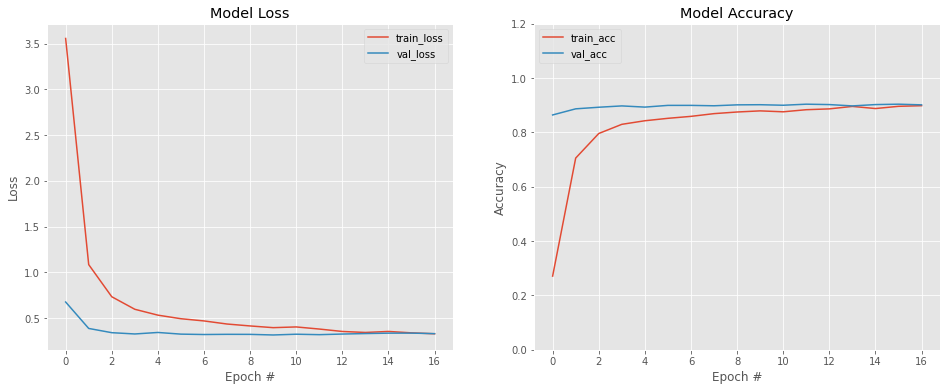


Starting fold 3
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1601 - accuracy: 0.9468


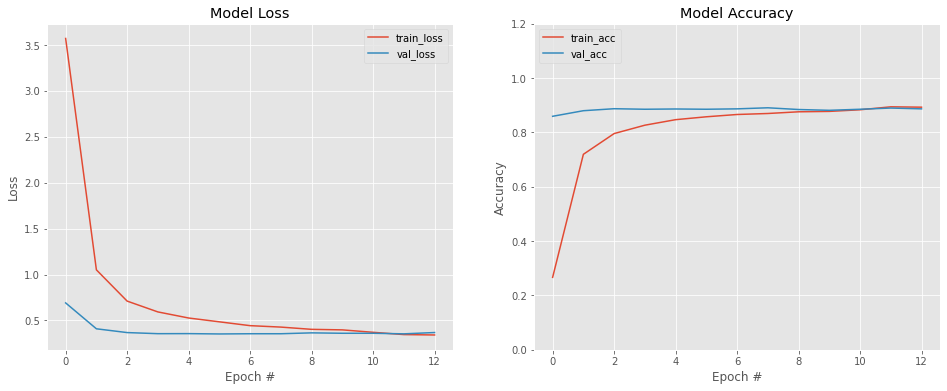


Starting fold 4
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1014 - accuracy: 0.9648


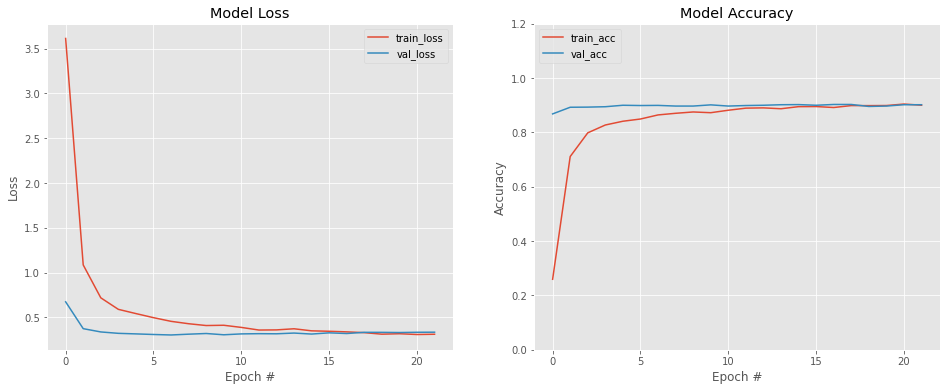


Starting fold 5
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.2607 - accuracy: 0.9206


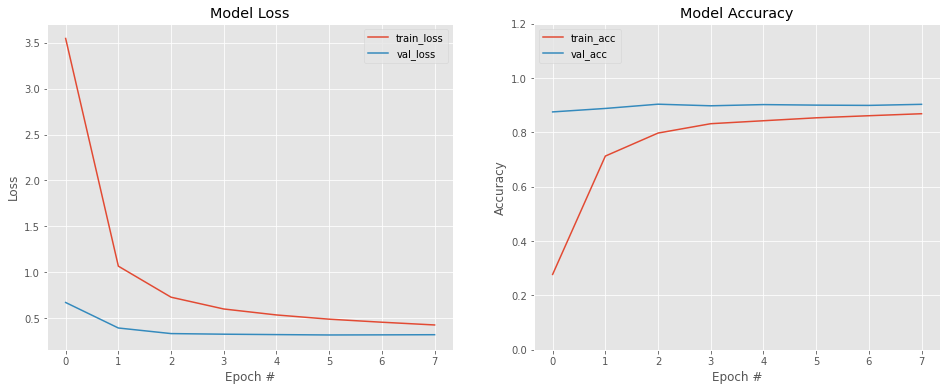


CV Score
TrainAccuracy 	avg: 0.94629 	max: 0.96478
TrainLoss 	avg: 0.16602 	min: 0.10143
ValAccuracy 	avg: 0.90139 	max: 0.90660
ValLoss 	avg: 0.32267 	min: 0.28495



In [ ]:
# Test whether the training is working
train_models = model_names[:3]
print(f"Feature extractions for {train_models}")
final_train_features = get_concat_features(train_models, feats_dict)

# Start training
_ = trainModels(final_train_features, Y)

## Evaluate the number of models to combine as an ensemble

In [ ]:
# list models to train for top n
list_train_models=[model_names[:i] for i in range(2, len(model_names)+1)]

# output file
cols = ["models", "ta_avg", "ta_max", "tl_avg", "tl_min", "va_avg", "va_max", "vl_avg", "vl_min"]
df_results = pd.DataFrame(columns=cols)

for train_models in list_train_models:
    print(f"Feature extractions for {train_models}")
    final_train_features = get_concat_features(train_models, feats_dict)
    trained_models, val_accuracy, val_losses, train_accuracy, train_losses = trainModels(final_train_features, Y, plot_model=False)
    
    # collect result
    result = np.array([train_models, avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
    df_results=df_results.append(pd.DataFrame(result.reshape(1,-1), columns=list(df_results)),  ignore_index=True)
    df_results.to_csv(f"{COLAB_FILEPATH}Datasets/output_topN.csv")

Feature extractions for ['Xception', 'DenseNet169']
collect features for Xception...
collect features for DenseNet169...

Starting fold 1
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1568 - accuracy: 0.9565

Starting fold 2
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.2669 - accuracy: 0.9294

Starting fold 3
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.2048 - accuracy: 0.9420

Starting fold 4
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1801 - accuracy: 0.9463

Starting fold 5
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.2390 - accuracy: 0.9324

CV Score
TrainAccuracy 	avg: 0.94133 	max: 0.95646
TrainLoss 	avg: 0.20951 	min: 0.15676
ValAccuracy 	avg: 0.87957 	max: 0.88503
ValLoss 	avg: 0.40572 	min: 0.37407

Feature extractio

In [ ]:
df_results

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,"[Xception, DenseNet169]",0.941328,0.956463,0.209515,0.15676,0.879574,0.885029,0.405721,0.374075
1,"[Xception, DenseNet169, InceptionResNetV2]",0.953483,0.961477,0.140108,0.111362,0.905203,0.91198,0.325119,0.300255
2,"[Xception, DenseNet169, InceptionResNetV2, Mob...",0.962336,0.969675,0.113056,0.0884004,0.90403,0.910024,0.337899,0.310554
3,"[Xception, DenseNet169, InceptionResNetV2, Mob...",0.969062,0.978357,0.0891184,0.0625924,0.906769,0.91047,0.343933,0.315836
4,"[Xception, DenseNet169, InceptionResNetV2, Mob...",0.979505,0.990462,0.0601294,0.0256396,0.905009,0.91047,0.393828,0.372157


From the above analysis, the best combination will be a combination of 3 models. We will now proceed to find all the combinations of 3 models from 5 of the best models

In [ ]:
import itertools

# list all possible combination for 5C3
list_train_models = list(itertools.combinations(model_names[:5], 3))

for train_models in list_train_models:
    print(train_models)

('Xception', 'DenseNet169', 'InceptionResNetV2')
('Xception', 'DenseNet169', 'MobileNet')
('Xception', 'DenseNet169', 'InceptionV3')
('Xception', 'InceptionResNetV2', 'MobileNet')
('Xception', 'InceptionResNetV2', 'InceptionV3')
('Xception', 'MobileNet', 'InceptionV3')
('DenseNet169', 'InceptionResNetV2', 'MobileNet')
('DenseNet169', 'InceptionResNetV2', 'InceptionV3')
('DenseNet169', 'MobileNet', 'InceptionV3')
('InceptionResNetV2', 'MobileNet', 'InceptionV3')


In [ ]:
# output file
cols = ["models", "ta_avg", "ta_max", "tl_avg", "tl_min", "va_avg", "va_max", "vl_avg", "vl_min"]
df_results = pd.DataFrame(columns=cols)

for train_models in list_train_models:
    print(f"Feature extractions for {train_models}")
    final_train_features = get_concat_features(train_models, feats_dict)
    trained_models, val_accuracy, val_losses, train_accuracy, train_losses = trainModels(final_train_features, Y, plot_model=False)
    
    # collect result
    result = np.array([train_models, avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
    df_results=df_results.append(pd.DataFrame(result.reshape(1,-1), columns=list(df_results)),  ignore_index=True)
    df_results.to_csv(f"{COLAB_FILEPATH}Datasets/output_5c3.csv")

Feature extractions for ('Xception', 'DenseNet169', 'InceptionResNetV2')
collect features for Xception...
collect features for DenseNet169...
collect features for InceptionResNetV2...

Starting fold 1
Training...

Epoch 00001: val_loss did not improve from 0.26657

Epoch 00002: val_loss did not improve from 0.26657

Epoch 00003: val_loss did not improve from 0.26657

Epoch 00004: val_loss did not improve from 0.26657

Epoch 00005: val_loss did not improve from 0.26657

Epoch 00006: val_loss did not improve from 0.26657

Epoch 00007: val_loss did not improve from 0.26657

Epoch 00008: val_loss did not improve from 0.26657

Epoch 00009: val_loss did not improve from 0.26657

Epoch 00010: val_loss did not improve from 0.26657

Epoch 00011: val_loss did not improve from 0.26657

Epoch 00012: val_loss did not improve from 0.26657

Epoch 00013: val_loss did not improve from 0.26657

Epoch 00014: val_loss did not improve from 0.26657

Epoch 00015: val_loss did not improve from 0.26657

Epoch 

In [ ]:
df_results

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,"(Xception, DenseNet169, InceptionResNetV2)",0.945632,0.95524,0.169148,0.140568,0.902562,0.907579,0.322615,0.292286
1,"(Xception, DenseNet169, MobileNet)",0.958545,0.967103,0.137381,0.0997687,0.878595,0.884597,0.403073,0.389603
2,"(Xception, DenseNet169, InceptionV3)",0.960648,0.97371,0.127074,0.0773867,0.895911,0.901663,0.345412,0.326285
3,"(Xception, InceptionResNetV2, MobileNet)",0.953777,0.968937,0.141012,0.0943296,0.900801,0.908068,0.327071,0.30371
4,"(Xception, InceptionResNetV2, InceptionV3)",0.958227,0.967103,0.122959,0.0931008,0.91078,0.913894,0.306852,0.291047
5,"(Xception, MobileNet, InceptionV3)",0.95111,0.964661,0.156464,0.102684,0.891899,0.894866,0.352568,0.332682
6,"(DenseNet169, InceptionResNetV2, MobileNet)",0.952456,0.958909,0.139327,0.120852,0.888279,0.895844,0.383242,0.349809
7,"(DenseNet169, InceptionResNetV2, InceptionV3)",0.947858,0.954996,0.1561,0.13558,0.902953,0.910024,0.316992,0.293546
8,"(DenseNet169, MobileNet, InceptionV3)",0.952921,0.972117,0.148551,0.0870892,0.876345,0.882641,0.416028,0.391319
9,"(InceptionResNetV2, MobileNet, InceptionV3)",0.956295,0.965146,0.129256,0.10483,0.902073,0.907534,0.34584,0.328879


Choose the combination which has the highest validation accuracy  
(Xception, InceptionResNetV2, InceptionV3)

### Training of the best combination and save its weights for the test set later on

## Xception-InceptionResNetV2-InceptionV3 Default Model

In [ ]:
# hyperparameters - default
batch_size=128
epochs=80
dropout=0.9
alpha=0.001
filename = 'xception-incepResNetV2-inceptionV3-bs128-dr0.9-lr0.001'

In [ ]:
# model checkpoint
saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}models/{filename}.h5',save_best_only=True,verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=0)
#reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=1e-6, verbose=0)

my_callback=[early_stopping,saved_weights]

Feature extractions for ('Xception', 'InceptionResNetV2', 'InceptionV3')
collect features for Xception...
collect features for InceptionResNetV2...
collect features for InceptionV3...

Starting fold 1
Training...

Epoch 00001: val_loss improved from inf to 0.44344, saving model to ./drive/My Drive/4041-dog-breed-classification/models/xception-incepResNetV2-inceptionV3-bs128-dr0.9-lr0.001.h5

Epoch 00002: val_loss improved from 0.44344 to 0.30165, saving model to ./drive/My Drive/4041-dog-breed-classification/models/xception-incepResNetV2-inceptionV3-bs128-dr0.9-lr0.001.h5

Epoch 00003: val_loss improved from 0.30165 to 0.29419, saving model to ./drive/My Drive/4041-dog-breed-classification/models/xception-incepResNetV2-inceptionV3-bs128-dr0.9-lr0.001.h5

Epoch 00004: val_loss improved from 0.29419 to 0.27928, saving model to ./drive/My Drive/4041-dog-breed-classification/models/xception-incepResNetV2-inceptionV3-bs128-dr0.9-lr0.001.h5

Epoch 00005: val_loss did not improve from 0.27928

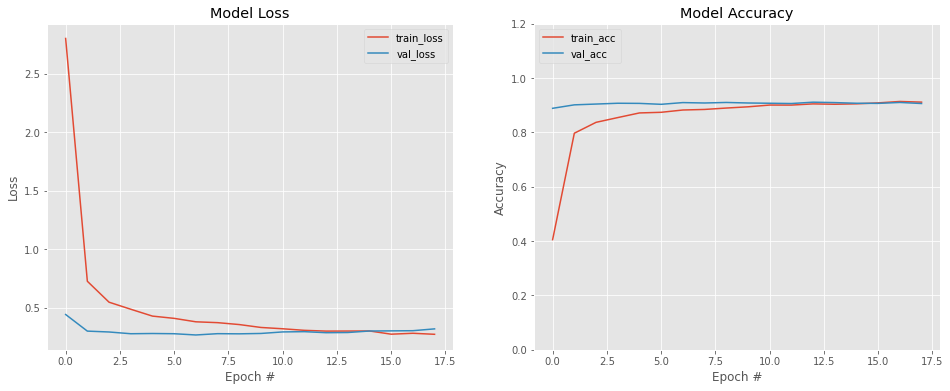


Starting fold 2
Training...

Epoch 00001: val_loss did not improve from 0.26869

Epoch 00002: val_loss did not improve from 0.26869

Epoch 00003: val_loss did not improve from 0.26869

Epoch 00004: val_loss did not improve from 0.26869

Epoch 00005: val_loss did not improve from 0.26869

Epoch 00006: val_loss did not improve from 0.26869

Epoch 00007: val_loss did not improve from 0.26869

Epoch 00008: val_loss did not improve from 0.26869

Epoch 00009: val_loss did not improve from 0.26869

Epoch 00010: val_loss did not improve from 0.26869

Epoch 00011: val_loss did not improve from 0.26869

Epoch 00012: val_loss did not improve from 0.26869

Epoch 00013: val_loss did not improve from 0.26869
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1400 - accuracy: 0.9539


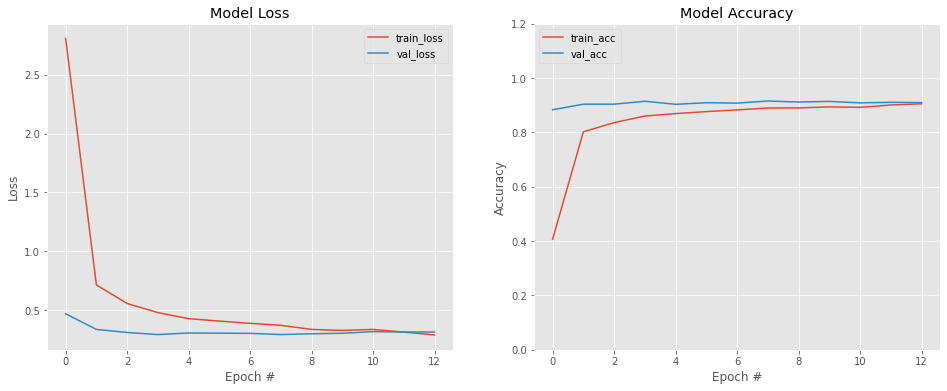


Starting fold 3
Training...

Epoch 00001: val_loss did not improve from 0.26869

Epoch 00002: val_loss did not improve from 0.26869

Epoch 00003: val_loss did not improve from 0.26869

Epoch 00004: val_loss did not improve from 0.26869

Epoch 00005: val_loss did not improve from 0.26869

Epoch 00006: val_loss did not improve from 0.26869

Epoch 00007: val_loss did not improve from 0.26869

Epoch 00008: val_loss did not improve from 0.26869

Epoch 00009: val_loss did not improve from 0.26869

Epoch 00010: val_loss did not improve from 0.26869

Epoch 00011: val_loss did not improve from 0.26869

Epoch 00012: val_loss did not improve from 0.26869

Epoch 00013: val_loss did not improve from 0.26869

Epoch 00014: val_loss did not improve from 0.26869

Epoch 00015: val_loss did not improve from 0.26869
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1210 - accuracy: 0.9590


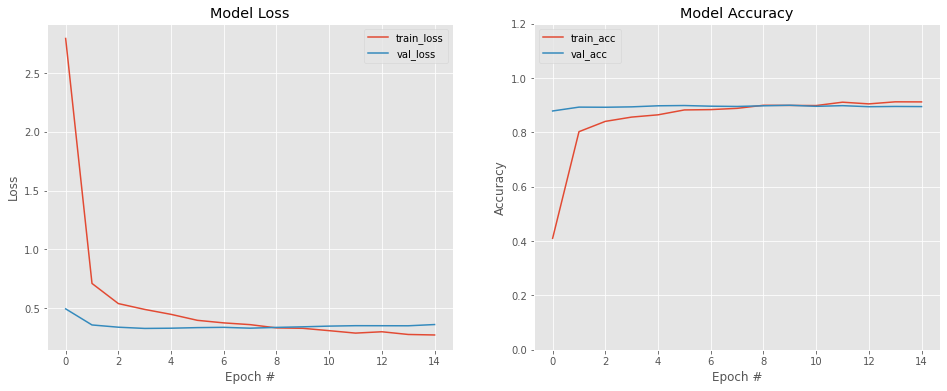


Starting fold 4
Training...

Epoch 00001: val_loss did not improve from 0.26869

Epoch 00002: val_loss did not improve from 0.26869

Epoch 00003: val_loss did not improve from 0.26869

Epoch 00004: val_loss did not improve from 0.26869

Epoch 00005: val_loss did not improve from 0.26869

Epoch 00006: val_loss did not improve from 0.26869

Epoch 00007: val_loss did not improve from 0.26869

Epoch 00008: val_loss did not improve from 0.26869

Epoch 00009: val_loss did not improve from 0.26869

Epoch 00010: val_loss did not improve from 0.26869

Epoch 00011: val_loss did not improve from 0.26869

Epoch 00012: val_loss did not improve from 0.26869

Epoch 00013: val_loss did not improve from 0.26869

Epoch 00014: val_loss did not improve from 0.26869

Epoch 00015: val_loss did not improve from 0.26869

Epoch 00016: val_loss did not improve from 0.26869
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1175 - accuracy: 0.9609


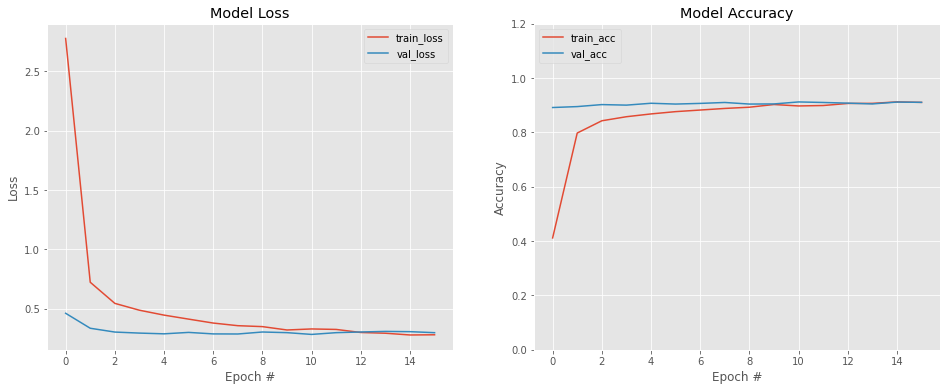


Starting fold 5
Training...

Epoch 00001: val_loss did not improve from 0.26869

Epoch 00002: val_loss did not improve from 0.26869

Epoch 00003: val_loss did not improve from 0.26869

Epoch 00004: val_loss did not improve from 0.26869

Epoch 00005: val_loss did not improve from 0.26869

Epoch 00006: val_loss did not improve from 0.26869

Epoch 00007: val_loss did not improve from 0.26869

Epoch 00008: val_loss did not improve from 0.26869

Epoch 00009: val_loss did not improve from 0.26869

Epoch 00010: val_loss did not improve from 0.26869

Epoch 00011: val_loss did not improve from 0.26869

Epoch 00012: val_loss did not improve from 0.26869

Epoch 00013: val_loss did not improve from 0.26869

Epoch 00014: val_loss did not improve from 0.26869

Epoch 00015: val_loss did not improve from 0.26869
Evaluating model ...
256/256 [==============================] - 1s 3ms/step - loss: 0.1241 - accuracy: 0.9566


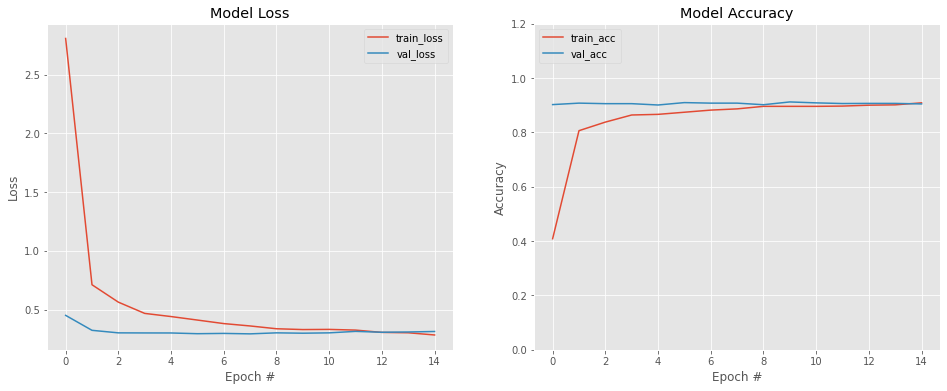


CV Score
TrainAccuracy 	avg: 0.95911 	max: 0.96515
TrainLoss 	avg: 0.12172 	min: 0.10590
ValAccuracy 	avg: 0.91000 	max: 0.91540
ValLoss 	avg: 0.30075 	min: 0.28308



In [ ]:
cols = ["models", "ta_avg", "ta_max", "tl_avg", "tl_min", "va_avg", "va_max", "vl_avg", "vl_min"]
df_results_best_default = pd.DataFrame(columns=cols)
train_models = ('Xception', 'InceptionResNetV2', 'InceptionV3')
tune_config = 'bs128-dr0.9-lr0.001-default'
print(f"Feature extractions for {train_models}")
final_train_features = get_concat_features(train_models, feats_dict)
trained_models, val_accuracy, val_losses, train_accuracy, train_losses = trainModels(final_train_features, Y, plot_model=True, best_model=True)

# collect result
#result = np.array([train_models, avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
result = np.array([tune_config, avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
df_results_best_default=df_results_best_default.append(pd.DataFrame(result.reshape(1,-1), columns=list(df_results_best)),  ignore_index=True)
df_results_best_default.to_csv(f"{COLAB_FILEPATH}Datasets/output_best_default.csv")

In [ ]:
df_results_best_default

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,bs128-dr0.9-lr0.001-default,0.9499368906021118,0.96086585521698,0.15609728544950485,0.11641420423984528,0.9091169357299804,0.9139364361763,0.3034540832042694,0.28684964776039124


## Hyperparameter tuning of the best model Xception-InceptionResNetV2-InceptionV3
We will tune 3 hyperparameters:  
- Batch Size  
- Dropout  
- Learning Rate   

**Possible hyperparameters**  
Batch Size: 32, 64, 128(default), 256    
Dropout: 0.7, 0.8, 0.9(default)   
Learning Rate: 0.001(default), 0.0001, 0.00001  

**A total of 4C1x3C1x3C1 = 36 choices of model**


In [ ]:
batch_size_list = [32,64,128,256]
dropout_list = [0.7,0.8,0.9]
alpha_list = [0.001, 0.0001, 0.00001]
epochs = 80

# output file
cols = ["models", "ta_avg", "ta_max", "tl_avg", "tl_min", "va_avg", "va_max", "vl_avg", "vl_min"]
df_results_best = pd.DataFrame(columns=cols)

for i in batch_size_list:
    for j in dropout_list:
        for k in alpha_list:
            # this is the default config
            if i==128 and j==0.9 and k==0.001:
                continue
            batch_size = i
            dropout = j
            alpha = k
            filename = f'xception-incepResNetV2-inceptionV3-bs{str(i)}-dr{str(j)}-lr{str(k)}'
            print(f"Feature extractions for bs{str(i)}-dr{str(j)}-lr{str(k)}")
            saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}models/{filename}.h5',save_best_only=True,verbose=0)
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=0)
            #reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=1e-6, verbose=0)
            my_callback=[early_stopping,saved_weights]

            final_train_features = get_concat_features(train_models, feats_dict)
            trained_models, val_accuracy, val_losses, train_accuracy, train_losses = trainModels(final_train_features, Y, plot_model=False, best_model=True)

            # collect result
            result = np.array([f'bs{str(i)}-dr{str(j)}-lr{str(k)}', avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
            df_results_best=df_results_best.append(pd.DataFrame(result.reshape(1,-1), columns=list(df_results_best)),  ignore_index=True)
            df_results_best.to_csv(f"{COLAB_FILEPATH}Datasets/output_best.csv")

Feature extractions for bs32-dr0.7-lr0.001
collect features for Xception...
collect features for InceptionResNetV2...
collect features for InceptionV3...

Starting fold 1
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.2466 - accuracy: 0.9249

Starting fold 2
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1245 - accuracy: 0.9593

Starting fold 3
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.2326 - accuracy: 0.9269

Starting fold 4
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1314 - accuracy: 0.9563

Starting fold 5
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.0922 - accuracy: 0.9692

CV Score
TrainAccuracy 	avg: 0.94732 	max: 0.96919
TrainLoss 	avg: 0.16546 	min: 0.09217
ValAccuracy 	avg: 0.89933 	max: 0.90856
ValLoss 	avg: 0.34472

In [ ]:
df_results_best

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,bs32-dr0.7-lr0.001,0.947319233417511,0.9691855907440186,0.16546147167682648,0.09217439591884613,0.8993337392807007,0.9085574746131897,0.3447200834751129,0.3220910429954529
1,bs32-dr0.7-lr0.0001,0.9549013614654541,0.9633162021636963,0.17534397542476654,0.13722768425941467,0.9106821060180664,0.915403425693512,0.3060495853424072,0.27016258239746094
2,bs32-dr0.7-lr1e-05,0.933648157119751,0.9455790519714355,0.3494193285703659,0.21564771234989166,0.9036386251449585,0.9110024571418762,0.43627543449401857,0.3213431239128113
3,bs32-dr0.8-lr0.001,0.9571755886077881,0.9645346999168396,0.1258496657013893,0.10203218460083008,0.9027586698532104,0.9070450067520142,0.34359162449836733,0.3192077577114105
4,bs32-dr0.8-lr0.0001,0.9495935440063477,0.9639276266098022,0.19229405224323273,0.13025152683258057,0.9092148780822754,0.9144254326820374,0.31557342410087585,0.2839815616607666
5,bs32-dr0.8-lr1e-05,0.9251122355461121,0.9360479116439819,0.45354809165000914,0.30956733226776123,0.9002145528793335,0.9046455025672913,0.5327878892421722,0.4177374243736267
6,bs32-dr0.9-lr0.001,0.9508414030075073,0.9592810273170471,0.15282901227474213,0.12648187577724457,0.9054970145225525,0.9134474396705627,0.35404601097106936,0.3141513466835022
7,bs32-dr0.9-lr0.0001,0.9462188839912414,0.9498655200004578,0.18019696772098542,0.1625160425901413,0.9116602897644043,0.9168704152107239,0.2903726100921631,0.2661762833595276
8,bs32-dr0.9-lr1e-05,0.9236940145492554,0.927846372127533,0.41203707456588745,0.32800933718681335,0.9005080938339234,0.9066014885902405,0.48297480344772337,0.4007464647293091
9,bs64-dr0.7-lr0.001,0.9754204154014587,0.9916850328445435,0.08063878491520882,0.03366044536232948,0.9030519366264343,0.9075342416763306,0.32890052199363706,0.30563023686408997


In [ ]:
# concatenate the default dataframe with the tuned models
frames = [df_results_best_default, df_results_best]
df_tuned = pd.concat(frames)
df_tuned

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,bs128-dr0.9-lr0.001-default,0.9591078162193298,0.9651461243629456,0.12171618938446045,0.1059013232588768,0.9099974155426025,0.915403425693512,0.300752991437912,0.2830755412578583
0,bs32-dr0.7-lr0.001,0.947319233417511,0.9691855907440186,0.16546147167682648,0.09217439591884613,0.8993337392807007,0.9085574746131897,0.3447200834751129,0.3220910429954529
1,bs32-dr0.7-lr0.0001,0.9549013614654541,0.9633162021636963,0.17534397542476654,0.13722768425941467,0.9106821060180664,0.915403425693512,0.3060495853424072,0.27016258239746094
2,bs32-dr0.7-lr1e-05,0.933648157119751,0.9455790519714355,0.3494193285703659,0.21564771234989166,0.9036386251449585,0.9110024571418762,0.43627543449401857,0.3213431239128113
3,bs32-dr0.8-lr0.001,0.9571755886077881,0.9645346999168396,0.1258496657013893,0.10203218460083008,0.9027586698532104,0.9070450067520142,0.34359162449836733,0.3192077577114105
4,bs32-dr0.8-lr0.0001,0.9495935440063477,0.9639276266098022,0.19229405224323273,0.13025152683258057,0.9092148780822754,0.9144254326820374,0.31557342410087585,0.2839815616607666
5,bs32-dr0.8-lr1e-05,0.9251122355461121,0.9360479116439819,0.45354809165000914,0.30956733226776123,0.9002145528793335,0.9046455025672913,0.5327878892421722,0.4177374243736267
6,bs32-dr0.9-lr0.001,0.9508414030075073,0.9592810273170471,0.15282901227474213,0.12648187577724457,0.9054970145225525,0.9134474396705627,0.35404601097106936,0.3141513466835022
7,bs32-dr0.9-lr0.0001,0.9462188839912414,0.9498655200004578,0.18019696772098542,0.1625160425901413,0.9116602897644043,0.9168704152107239,0.2903726100921631,0.2661762833595276
8,bs32-dr0.9-lr1e-05,0.9236940145492554,0.927846372127533,0.41203707456588745,0.32800933718681335,0.9005080938339234,0.9066014885902405,0.48297480344772337,0.4007464647293091


In [ ]:
df_tuned.to_csv(f"{COLAB_FILEPATH}Datasets/output_tuned.csv", index=False)

### import dataframe to check

In [ ]:
a = pd.read_csv(f"{COLAB_FILEPATH}Datasets/output_tuned.csv")
a.head(3)

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,bs128-dr0.9-lr0.001-default,0.959108,0.965146,0.121716,0.105901,0.909997,0.915403,0.300753,0.283076
1,bs32-dr0.7-lr0.001,0.947319,0.969186,0.165461,0.092174,0.899334,0.908557,0.344720,0.322091
2,bs32-dr0.7-lr0.0001,0.954901,0.963316,0.175344,0.137228,0.910682,0.915403,0.306050,0.270163


## import the test data an do pre-processing

In [ ]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH_TEST)
print(loaded.files)
Xarr = loaded["X"]
del loaded
gc.collect()

print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X']
Time taken to load compressed data: 32.777629137039185


In [ ]:
# print out shape, dtype and data size
nparray_info("Images (npz)", Xarr)

Images (npz)
-  shape	 (10357, 299, 299, 3)
-  dtype	 uint8
- nbytes	 2777778471 (2.59 GB)


## Extract features of the test set using the same combination of models we selected to train our best 3 models

In [ ]:
def extact_features(data):
    xception_features = get_valfeatures(Xception, xception_preprocessor, data)
    inc_resnet_features = get_valfeatures(InceptionResNetV2,inc_resnet_preprocessor,data)
    inception_features = get_valfeatures(InceptionV3, inception_preprocessor, data)

    final_features = np.concatenate([
                                     xception_features,
                                     inc_resnet_features,
                                     inception_features
                                     ],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del inc_resnet_features
    del xception_features
    
    gc.collect()
    
    return final_features

test_features = extact_features(Xarr)

162/162 [==============================] - 114s 489ms/step
Feature maps
-  shape	 (10357, 2048)
-  dtype	 float32
- nbytes	 84844544 (80.91 MB)
162/162 [==============================] - 107s 606ms/step
Feature maps
-  shape	 (10357, 1536)
-  dtype	 float32
- nbytes	 63633408 (60.69 MB)
162/162 [==============================] - 42s 231ms/step
Feature maps
-  shape	 (10357, 2048)
-  dtype	 float32
- nbytes	 84844544 (80.91 MB)
Final feature maps shape (10357, 5632)


In [ ]:
test_features

array([[0.        , 0.01405761, 0.00206047, ..., 0.35490984, 0.07233112,
        0.24632105],
       [0.        , 0.02713269, 0.        , ..., 0.4363294 , 0.82570016,
        0.33107263],
       [0.11419057, 0.06636836, 0.        , ..., 0.32171142, 0.17528112,
        0.01769355],
       ...,
       [0.05377474, 0.5438797 , 0.        , ..., 0.6036058 , 0.81560415,
        0.30032447],
       [0.        , 0.42156357, 0.01432103, ..., 0.42016995, 0.0478144 ,
        0.23286901],
       [0.13394712, 0.01846582, 0.21070862, ..., 0.5512834 , 1.1504506 ,
        0.07801542]], dtype=float32)

# Testing phase on one model

## load the pretrained ensemble model

In [ ]:
# load the top 3 fine-tuned model
model_bs32_dr09_lr1e4 = load_model(COLAB_FILEPATH+'models/xception-incepResNetV2-inceptionV3-bs32-dr0.9-lr0.0001.h5')
model_bs128_dr08_lr1e4 = load_model(COLAB_FILEPATH+'models/xception-incepResNetV2-inceptionV3-bs128-dr0.8-lr0.0001.h5')
model_bs128_dr09_lr1e4 = load_model(COLAB_FILEPATH+'models/xception-incepResNetV2-inceptionV3-bs128-dr0.9-lr0.0001.h5')

### Try out on the first prediction on one of the best model

In [ ]:
# make prediction with our trained model
pred_bs32_dr09_lr1e4 = model_bs32_dr09_lr1e4.predict(test_features)
pred_bs128_dr08_lr1e4 = model_bs128_dr08_lr1e4.predict(test_features)
pred_bs128_dr09_lr1e4 = model_bs128_dr09_lr1e4.predict(test_features)

In [ ]:
# First prediction for one of the model
print(pred_bs32_dr09_lr1e4[0])
# the max probability value predicted by the model
print(f"Max value (probability of prediction): {np.max(pred_bs32_dr09_lr1e4[0])}")
# because we used softmax activation in our model, this will be close to 1 
print(f"Sum: {np.sum(pred_bs32_dr09_lr1e4[0])}") 
# the index of where the max value in predictions[0] occurs
print(f"Max index: {np.argmax(pred_bs32_dr09_lr1e4[0])}") 
print(f"Predicted label: {breeds[np.argmax(pred_bs32_dr09_lr1e4[0])]}")

[1.8056136e-06 8.0280029e-07 5.9576217e-07 3.0772236e-07 2.9884808e-07
 2.2689224e-07 1.3580822e-07 4.8308209e-07 2.0699538e-07 6.9496457e-07
 1.7919938e-07 3.3120946e-07 1.1670921e-06 9.0623100e-05 3.8257824e-07
 7.0232215e-07 5.9203705e-07 4.3786812e-08 5.6557468e-07 3.6349841e-06
 2.4335577e-07 2.1792177e-06 3.4374825e-06 1.0441109e-07 4.0848431e-07
 1.2938298e-06 5.2861520e-08 2.1633325e-07 1.9556126e-07 4.8825127e-06
 7.7179817e-07 4.2946144e-07 1.7522317e-06 2.3334264e-06 5.8768808e-07
 1.1565457e-07 3.7369520e-07 2.3158053e-07 1.2324963e-06 7.1717079e-07
 4.4974735e-07 1.0022294e-06 7.5039600e-07 6.5562034e-07 3.2749409e-07
 1.8995825e-06 5.7540429e-08 7.6324596e-07 4.7701076e-07 2.0146074e-06
 1.1099499e-06 1.4637401e-06 8.5307659e-07 2.4577980e-07 7.6767527e-08
 2.6544635e-07 3.4013067e-07 6.3899279e-08 1.2000453e-07 2.3068428e-07
 3.2642518e-07 9.9592304e-01 4.6485653e-07 1.3476139e-07 3.9474818e-07
 9.5721120e-08 1.9893113e-07 4.8904889e-07 1.2436344e-07 2.7110499e-07
 1.786

### Initialise an empty pandas DataFrame to store prediction

In [ ]:
# import a list of test filenames
fn = pd.read_csv(f'{COLAB_FILEPATH}Datasets/test_set_id.csv')
fn.head()

,id
0,000621fb3cbb32d8935728e48679680e
1,00102ee9d8eb90812350685311fe5890
2,0012a730dfa437f5f3613fb75efcd4ce
3,001510bc8570bbeee98c8d80c8a95ec1
4,001a5f3114548acdefa3d4da05474c2e


In [ ]:
# initialise an empty dataframe with only headers
df_pred_bs32_dr09_lr1e4 = pd.DataFrame(columns=["id"] + list(breeds))
df_pred_bs128_dr08_lr1e4 = pd.DataFrame(columns=["id"] + list(breeds))
df_pred_bs128_dr09_lr1e4 = pd.DataFrame(columns=["id"] + list(breeds))

In [ ]:
# append the column of the test set filename
df_pred_bs32_dr09_lr1e4['id'] = fn['id']
df_pred_bs128_dr08_lr1e4['id'] = fn['id']
df_pred_bs128_dr09_lr1e4['id'] = fn['id']

In [ ]:
# get the prediction score
df_pred_bs32_dr09_lr1e4.loc[:,list(breeds)]= pred_bs32_dr09_lr1e4
df_pred_bs128_dr08_lr1e4.loc[:,list(breeds)]= pred_bs128_dr08_lr1e4
df_pred_bs128_dr09_lr1e4.loc[:,list(breeds)]= pred_bs128_dr09_lr1e4

In [ ]:
df_pred_bs32_dr09_lr1e4.to_csv(f'{COLAB_FILEPATH}Datasets/submission_bs32_dr09_lr1e4.csv',index=None)
df_pred_bs128_dr08_lr1e4.to_csv(f'{COLAB_FILEPATH}Datasets/submission_bs128_dr08_lr1e4.csv',index=None)
df_pred_bs128_dr09_lr1e4.to_csv(f'{COLAB_FILEPATH}Datasets/submission_bs128_dr09_lr1e4.csv',index=None)